In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import normalize

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def select_features_from_lasso(X, y, alpha):
    # fit lasso model and pass to select from model
    Xtrain =normalize(X)
    lasso = Lasso(alpha).fit(Xtrain, y)
    model = SelectFromModel(lasso, prefit=True)

    # new features
    X_new = model.transform(X)
    return X.columns[model.get_support()]

In [3]:
def backward_stepwise(X, y):
    model = LinearRegression()

    vars_remaining = []
    vars_in_model = list(X.columns)
    
    last_error = cross_val_score(model, X[vars_in_model], y, cv=10, scoring="neg_mean_squared_error").mean()
    
    for _ in range(len(vars_in_model)):
        scores = []
        for var in vars_in_model:
            candidate_vars = copy.copy(vars_in_model)
            candidate_vars.remove(var)
            Xtrain = X[candidate_vars]
            scores.append(
                cross_val_score(model, normalize(Xtrain), y, cv=10, scoring="neg_mean_squared_error").mean()
            )
        i = np.argmax(scores)
        if scores[i] <= last_error:
            break
        else:
            last_error = scores[i]
            del vars_in_model[i]
            
    return vars_in_model

In [4]:
def forward_stepwise(X, y):
    model = LinearRegression()

    vars_remaining = list(X.columns)
    vars_in_model = []
    last_error = -np.inf

    for _ in range(len(vars_remaining)):
        scores = []
        for var in vars_remaining:
            candidate_vars = vars_in_model + [var]
            Xtrain = X[candidate_vars]
            scores.append(
                cross_val_score(model, normalize(Xtrain), y, cv=10, scoring="neg_mean_squared_error").mean()
            )
        i = np.argmax(scores)
        if scores[i] <= last_error:
            break
        else:
            last_error = scores[i]
            var_to_add = vars_remaining[i]
            vars_in_model.append(var_to_add)
            del vars_remaining[i]

    return vars_in_model

In [5]:
def get_categorical_numeric(df):
    numerics = []
    categorical = []

    for col in df:
        if((df[col].dtype == np.float64 or df[col].dtype == np.int64) and col != 'Unnamed: 0'):
            numerics.append(col)

        else:
            categorical.append(col)

    categorical_df = df[categorical]
    numeric_df = df[numerics]
    
    return categorical_df, numeric_df

In [6]:
def remove_categorical(X, feat, columns):
    for col in columns:
        if col in X:
            keep = []

            for f in feat:
                if col + '_' in f:
                    keep.append(f.replace(col + '_', ''))

            X[col][~(X[col].isin(keep))] = 'other'

In [23]:
""" 
 use lasso regression to select columns for the model
 try a range of alpha parameters on the lasso model
 mode can be just categorical, numerical, or both
"""
def train_lasso(X, y, alphas=[1e-2, 1, 10, 1e2, 1e3, 1e4], mode = "numerical"):
    mse = []
    df = pd.read_csv('train.csv').dropna()
    y = df[['Total Household Income']]
    df = df.drop(['Total Household Income', 'Unnamed: 0'], axis=1)
    categorical_df, numeric_df = get_categorical_numeric(df)
    
    for alpha in alphas:
        reg = LinearRegression()
        
        # only used categorical features
        # values not selected by lasso will be set to other
        if mode == "categorical":
            tmp = pd.get_dummies(categorical_df, columns = categorical_df.columns)
            new_feat = select_features_from_lasso(tmp, y, alpha)
            remove_categorical(categorical_df, new_feat, categorical_df.columns)
            categorical_df = pd.get_dummies(categorical_df, columns = categorical_df.columns)
            
            print ("Using alpha of {0} {1} columns were selected".format(alpha, len(new_feat)))
            print
            
            scores = cross_val_score(reg, categorical_df, y, cv=5, scoring='neg_mean_squared_error')
           
        # only use numerical features, and normalize the data
        elif mode == "numerical":
            new_feat = select_features_from_lasso(numeric_df, y, alpha)
            Xnum = normalize(numeric_df[new_feat])
            
            print ("Using alpha of {0} {1} columns were selected".format(alpha, len(new_feat)))
            print
            
            scores = cross_val_score(reg, normalize(Xnum), y, cv=5, scoring='neg_mean_squared_error')
        
        # use both features
        else:
            new_feat = select_features_from_lasso(pd.get_dummies(categorical_df, categorical_df.columns), y, alpha)
            remove_categorical(categorical_df, new_feat, categorical_df.columns)
            categorical_df = pd.get_dummies(categorical_df, columns = categorical_df.columns)
            
            new_feat = select_features_from_lasso(numeric_df, y, alpha)
            Xnum = pd.DataFrame(normalize(numeric_df[new_feat]))
            
            print ("Using alpha of {0} {1} columns were selected".format(alpha, len(categorical_df.columns) + 
                                                                         Xnum.shape[1]))
            print
            
            total = pd.concat([Xnum, categorical_df], axis = 1)
            scores = cross_val_score(reg, total, y, cv=5, scoring='neg_mean_squared_error')

        print ("Alpha: {0}, MSE {1}".format(alpha, np.mean(scores)))
        print 

        mse.append(np.mean(scores))
        
    return mse

In [8]:
df = pd.read_csv('train.csv').dropna()
categorical_df, numeric_df = get_categorical_numeric(df)

In [9]:
assert len(df) == len(categorical_df) == len(numeric_df)
assert len(df.columns) == len(categorical_df.columns) + len(numeric_df.columns)

### Predict household income from just numerical features

In [10]:
X = numeric_df.drop(['Total Household Income'], axis=1)
y = numeric_df[['Total Household Income']]

### Use average household income to train regression model and produce a baseline MSE
### Very high baseline?

In [11]:
reg = LinearRegression()
scores = cross_val_score(reg, X, [np.mean(y) for _ in range(len(y))], cv=5, scoring='neg_mean_squared_error')
print ("Baseline MSE is {0}".format(np.mean(scores)))

Baseline MSE is -8.47032947254e-22


### Lasso  regression to select numerical features
### Normalize features first? (Increased MSE ...)
### Alpha = 100 selected 18 columns and produced the best MSE

In [12]:
mse = train_lasso(X, y)

Using alpha of 0.01 39 columns were selected

Alpha: 0.01, MSE -50581751798.0

Using alpha of 1 24 columns were selected

Alpha: 1, MSE -53638487610.3

Using alpha of 10 22 columns were selected

Alpha: 10, MSE -53937993958.5

Using alpha of 100.0 18 columns were selected

Alpha: 100.0, MSE -55399292100.1

Using alpha of 1000.0 11 columns were selected

Alpha: 1000.0, MSE -55968510628.6

Using alpha of 10000.0 2 columns were selected

Alpha: 10000.0, MSE -67680197724.9



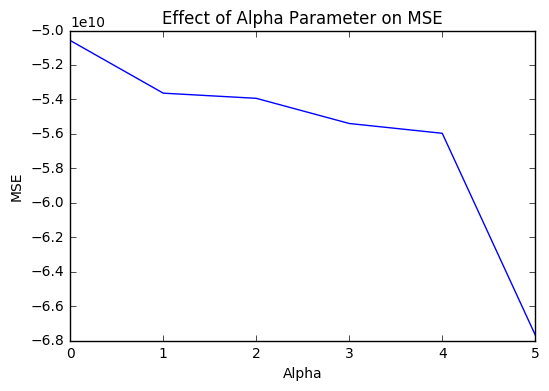

In [13]:
plt.plot(mse)
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('Effect of Alpha Parameter on MSE')
plt.show()

### Backward stepwise did not take any columns

In [14]:
new_feat = backward_stepwise(X, y)
Xnew = normalize(X[new_feat])
reg = LinearRegression()
scores = cross_val_score(reg, Xnew, y, cv=5, scoring='neg_mean_squared_error').mean()
print "Using backward stepwise regression {0} columns were selected with an average MSE of {1}".format(len(new_feat), scores)

Using backward stepwise regression 44 columns were selected with an average MSE of -50566283116.9


### Forward stepwise selected 20 columns

In [15]:
new_feat = forward_stepwise(X, y)
Xnew = normalize(X[new_feat])
reg = LinearRegression()
scores = cross_val_score(reg, Xnew, y, cv=5, scoring='neg_mean_squared_error').mean()
print "Using forward stepwise regression {0} columns were selected with an average MSE of {1}".format(len(new_feat), scores)

Using forward stepwise regression 20 columns were selected with an average MSE of -42117446845.8


### Predict household income from just categorical features

In [16]:
X = categorical_df.drop(['Unnamed: 0'], axis = 1)
y = numeric_df[['Total Household Income']]

In [17]:
assert len(X) == len(categorical_df) == len(y)

### 500 columns after one-hot encoding and including all variables
### Household head occupation has 370 unique values (can probably be reduced)

In [18]:
X = pd.get_dummies(X, columns = X.columns)

In [19]:
X.head()

,Region_ ARMM,Region_CAR,Region_Caraga,Region_I - Ilocos Region,Region_II - Cagayan Valley,Region_III - Central Luzon,Region_IVA - CALABARZON,Region_IVB - MIMAROPA,Region_IX - Zasmboanga Peninsula,Region_NCR,...,"Main Source of Water Supply_Lake, river, rain and others",Main Source of Water Supply_Others,"Main Source of Water Supply_Own use, faucet, community water system","Main Source of Water Supply_Own use, tubed/piped deep well",Main Source of Water Supply_Peddler,"Main Source of Water Supply_Protected spring, river, stream, etc","Main Source of Water Supply_Shared, faucet, community water system","Main Source of Water Supply_Shared, tubed/piped deep well",Main Source of Water Supply_Tubed/piped shallow well,"Main Source of Water Supply_Unprotected spring, river, stream, etc"
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Alpha = 100 produced the best MSE and selected 79 columns
### For categorical variables, if the variable is chosen by lasso keep it, otherwise
### set it to an "other". Use the new dataframe in a linear regression model to
### get the mse

In [24]:
mse = train_lasso(X, y, mode='categorical')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using alpha of 0.01 497 columns were selected

Alpha: 0.01, MSE -9.04884828341e+30



/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using alpha of 1 265 columns were selected

Alpha: 1, MSE -82693528373.4



//anaconda/lib/python2.7/site-packages/sklearn/feature_selection/base.py:80: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  UserWarning)


Using alpha of 10 0 columns were selected

Alpha: 10, MSE -82693528373.4

Using alpha of 100.0 0 columns were selected

Alpha: 100.0, MSE -82693528373.4



KeyboardInterrupt: 

### Use all the features to compute the MSE

In [ ]:
mse = train_lasso(X, y, mode='both')